In [5]:
import copy
import random
import pickle
import os
import sys
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import pickle

from utilities.data_structures.Config import Config
from agents.DQN_agents.DDQN import DDQN
from agents.DQN_agents.DQN_With_Fixed_Q_Targets import DQN_With_Fixed_Q_Targets

config = Config()
config.seed = 1
config.num_episodes_to_run = 1000
config.file_to_save_data_results = "results/data_and_graphs/Cart_Pole_Results_Data.pkl"
config.file_to_save_results_graph = "results/data_and_graphs/Cart_Pole_Results_Graph.png"
config.show_solution_score = False
config.visualise_individual_results = False
config.visualise_overall_agent_results = True
config.standard_deviation_results = 1.0
config.runs_per_agent = 1
config.use_GPU = True
config.overwrite_existing_results_file = False
config.randomise_random_seed = True
config.save_model = True
config.device = 2


hyperparameters = {
    "DQN_Agents": {
        "learning_rate": 1e-5,
        "batch_size": 32,
        "buffer_size": 200000,
        "epsilon": 0.01,
        "epsilon_decay_rate_denominator": 1,
        "discount_rate": 0.99,
        "tau": 1e-4,
        "alpha_prioritised_replay": 0.6,
        "beta_prioritised_replay": 0.1,
        "incremental_td_error": 1e-8,
        "update_every_n_steps": 1,
        "learning_iterations": 1,
        "final_layer_activation": "None",
        "batch_norm": False,
        "gradient_clipping_norm": 0.7,
        "clip_rewards": False
    },
    "Stochastic_Policy_Search_Agents": {
        "policy_network_type": "Linear",
        "noise_scale_start": 1e-2,
        "noise_scale_min": 1e-3,
        "noise_scale_max": 2.0,
        "noise_scale_growth_factor": 2.0,
        "stochastic_action_decision": False,
        "num_policies": 10,
        "episodes_per_policy": 1,
        "num_policies_to_keep": 5,
        "clip_rewards": False
    },
    "Policy_Gradient_Agents": {
        "learning_rate": 0.05,
        "linear_hidden_units": [20, 20],
        "final_layer_activation": "SOFTMAX",
        "learning_iterations_per_round": 5,
        "discount_rate": 0.99,
        "batch_norm": False,
        "clip_epsilon": 0.1,
        "episodes_per_learning_round": 4,
        "normalise_rewards": True,
        "gradient_clipping_norm": 7.0,
        "mu": 0.0, #only required for continuous action games
        "theta": 0.0, #only required for continuous action games
        "sigma": 0.0, #only required for continuous action games
        "epsilon_decay_rate_denominator": 1.0,
        "clip_rewards": False
    },

    "Actor_Critic_Agents":  {

        "learning_rate": 0.005,
        "linear_hidden_units": [20, 10],
        "final_layer_activation": ["SOFTMAX", None],
        "gradient_clipping_norm": 5.0,
        "discount_rate": 0.99,
        "epsilon_decay_rate_denominator": 1.0,
        "normalise_rewards": True,
        "exploration_worker_difference": 2.0,
        "clip_rewards": False,

        "Actor": {
            "learning_rate": 0.0003,
            "linear_hidden_units": [64, 64],
            "final_layer_activation": "Softmax",
            "batch_norm": False,
            "tau": 0.005,
            "gradient_clipping_norm": 5,
            "initialiser": "Xavier"
        },

        "Critic": {
            "learning_rate": 0.0003,
            "linear_hidden_units": [64, 64],
            "final_layer_activation": None,
            "batch_norm": False,
            "buffer_size": 1000000,
            "tau": 0.005,
            "gradient_clipping_norm": 5,
            "initialiser": "Xavier"
        },

        "min_steps_before_learning": 400,
        "batch_size": 256,
        "discount_rate": 0.99,
        "mu": 0.0, #for O-H noise
        "theta": 0.15, #for O-H noise
        "sigma": 0.25, #for O-H noise
        "action_noise_std": 0.2,  # for TD3
        "action_noise_clipping_range": 0.5,  # for TD3
        "update_every_n_steps": 1,
        "learning_updates_per_learning_session": 1,
        "automatically_tune_entropy_hyperparameter": True,
        "entropy_term_weight": None,
        "add_extra_noise": False,
        "do_evaluation_iterations": True
    }
}



# Model and Env wrapper, currently Breakout and CartPole implemented

In [6]:
frames = 3
class CNN(nn.Module):
    """input resized to [84, 84, 1]"""
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv2d(frames, 32, kernel_size = 8, stride = 4)
        # 20 20
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
        # 9 9
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)
        # 7 7
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class NN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
class Wrapper(gym.ObservationWrapper):
    def __init__(self, environment):
        super().__init__(environment)
        
    def reset(self):
        state = super().reset()
        self.state = np.concatenate([state for i in range(frames)], axis=0)
        return self.state

    def observation(self, state):
        return self.process(state)
    
    def step(self, action):
        state, reward, done, info = super().step(action)
        self.state = np.concatenate([self.state[1:frames], state], axis=0)
        if info["ale.lives"]!=5:
            done = True
        return self.state, reward, done, info
    
    def process(self, state):
        state = Image.fromarray(state)
        state = state.crop(box = [0, 34, 160, 194])
        state = state.convert(mode="L")
        state = state.resize((84, 84))
        state = np.array(state)
        return state.reshape(1, 84, 84)

# Initialization

In [7]:
record = False
load = True
if record:
    from pyvirtualdisplay import Display
    # opens a virtual monitor, for outputting videos
    monitor = Display(visible=0, size=(210, 160))
    monitor.start()


config.model_class = CNN
env = Wrapper(gym.make('BreakoutDeterministic-v4'))


"""
config.model_class = NN
env = gym.make('CartPole-v0')
"""


if record:
    env =  gym.wrappers.Monitor(env, "tmp", force=True)
config.environment = env
#config.environment = gym.make('CartPole-v0')
config.hyperparameters = hyperparameters["DQN_Agents"]
agent = DDQN(config)

if load:
    checkpoint = torch.load("./checkpoint1")
    agent.q_network_local.load_state_dict(checkpoint['model_dict'])
    agent.q_network_target.load_state_dict(checkpoint['model_dict'])

TITLE  BreakoutDeterministic
Score required to win set to infinity therefore no learning rate annealing will happen


# Train

In [ ]:
save = True
agent.set_random_seeds(90)
# donnot reset the epsiode number (that resets eps-greddy) increase the n_episodes instead
for i in range(50):
    game_scores, rolling_scores, time_taken = agent.run_n_episodes(i*1000)
    if save:
        torch.save({'model_dict': agent.q_network_local.state_dict()}, "checkpoint%d"%i)

 
DDQN did not achieve required score 

 Episode 356, Score:  0.00, Max score seen:  9.00, Rolling score:  0.68, Max rolling score seen:  0.92"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# Visualization

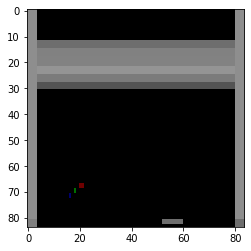

In [85]:
env.reset()
for i in range(12):
    state, reward, done, info  = env.step(1)
    if done == True:
        print(i)
        break
plt.imshow(state.transpose(1,2,0))

In [71]:
state.shape

(1, 84, 84)

In [56]:
np.concatenate([x, x])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

# S/L

In [9]:
checkpoint = torch.load("./checkpoint1")
agent.q_network_local.load_state_dict(checkpoint['model_dict'])
agent.q_network_target.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [25]:
torch.save({'model_dict': agent.q_network_local.state_dict()}, "checkpoint4")

# Discussion

refer to https://openai.com/blog/openai-baselines-dqn/, for best practices and the 2013 paper https://arxiv.org/pdf/1312.5602.pdf).

The MNIST and CIFAR of RL

4 dim parameterized CartPole can be solved (keeping balance for more than 200 frames on average) within 500 episodes.
LR 1e-2, tau 1e-2.

Pong-ram-v0 and Pong-v0 image

As for image input, BreakoutDeterministic-v4. 10M transitions is a common setting, and it is okay to have no improvements during the first 1M transitions (perhaps due to high eps). LR 1e-5, tau 1e-4, average of 11 is obtained using a single frame(incomplete state). DeepMind takes last 4 frames as input.

Changes
Implemented real eps-greedy
now supports setting the device